In [1]:

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import astropy.time as at
import astropy.coordinates as ac
import astropy.units as au
import gpflow as gp
from bayes_filter.datapack import DataPack
from bayes_filter.misc import make_coord_array, get_screen_directions
from bayes_filter.coord_transforms import ITRSToENUWithReferences
from bayes_filter.settings import dist_type, angle_type
from bayes_filter.kernels import DTECIsotropicTimeGeneral
from bayes_filter.plotting import plot_vornoi_map
from bayes_filter import logging
import pylab as plt
from scipy.special import erf

from functools import reduce
import warnings

import tensorflow as tf
import numpy as np
import gpflow as gp

from gpflow import transforms
from gpflow import settings

from gpflow.params import Parameter, Parameterized, ParamList
from gpflow.decors import params_as_tensors, autoflow

float_type = settings.float_type

    
class DTECKernel(gp.kernels.Kernel):
    def __init__(self, input_dim, variance=1., lengthscales=10.0,
                 a = 200., b = 100., resolution=10,
                 active_dims=None, fed_kernel='RBF', obs_type='DTEC',name=None):
        """
        - input_dim is the dimension of the input to the kernel
        - variance is the (initial) value for the variance parameter
        - lengthscales is the initial value for the lengthscales parameter
          defaults to 1.0 (ARD=False) or np.ones(input_dim) (ARD=True).
        - active_dims is a list of length input_dim which controls which
          columns of X are used.
        """
        super().__init__(input_dim, active_dims, name=name)
        self.variance = Parameter(variance, transform=transforms.positiveRescale(variance),
                                  dtype=settings.float_type)
        # (3,)
        self.lengthscales = Parameter(lengthscales, transform=transforms.positiveRescale(lengthscales),
                                      dtype=settings.float_type)
        self.a = Parameter(a, transform=transforms.positiveRescale(a),
                                      dtype=settings.float_type)
        self.b = Parameter(b, transform=transforms.positiveRescale(b),
                                      dtype=settings.float_type)
        self.resolution = resolution
        self.obs_type = obs_type
        self.fed_kernel = fed_kernel

    @params_as_tensors
    def Kdiag(self, X, presliced=False):
        if not presliced:
            X, _ = self._slice(X, None)
        return tf.diag_part(self.K(X,None))

    @params_as_tensors
    def K(self, X, X2=None, presliced=False):
        
        if not presliced:
            X, X2 = self._slice(X, X2)
            
        kern = DTECIsotropicTimeGeneral(variance=self.variance, lengthscales=self.lengthscales,
                                a= self.a, b=self.b, fed_kernel=self.fed_kernel, obs_type=self.obs_type,
                               squeeze=True,#ode_type='adaptive',
                               kernel_params={'resolution':self.resolution})
        return kern.K(X,X2)
    
import tensorflow as tf

from gpflow import likelihoods
from gpflow import settings

from gpflow.conditionals import base_conditional
from gpflow.params import DataHolder
from gpflow.decors import params_as_tensors
from gpflow.decors import name_scope
from gpflow.logdensities import multivariate_normal

from gpflow.models.model import GPModel


class HGPR(GPModel):
    r"""
    Gaussian Process Regression.
    This is a vanilla implementation of GP regression with a Gaussian
    likelihood. In this case inference is exact, but costs O(N^3). This means
    that we can compute the predictive distributions (predict_f, predict_y) in
    closed-form, as well as the marginal likelihood, which we use to estimate
    (optimize) the kernel parameters. 
    
    Multiple columns of Y are treated independently, using the same kernel. 
    The log likelihood of this model is sometimes referred to as the
    'marginal log likelihood', and is given by
    .. math::
       \log p(\mathbf y | \mathbf f) = \mathcal N(\mathbf y | 0, \mathbf K + \sigma_n \mathbf I)
    """
    def __init__(self, X, Y, Y_var, kern, mean_function=None, name=None):
        """
        X is a data matrix, size N x D
        Y is a data matrix, size N x R
        kern, mean_function are appropriate GPflow objects
        name is a string which can be used to name this model (useful for handling multiple models on one tf.graph)
        """
        likelihood = likelihoods.Gaussian()
        # M, D
        X = DataHolder(X)
        # T, M
        Y = DataHolder(Y)
        num_latent = Y.shape[0]
        GPModel.__init__(self, X=X, Y=Y, kern=kern, likelihood=likelihood,
                         mean_function=mean_function, num_latent=num_latent, name=name)
        self.Y_var = DataHolder(Y_var)

    @name_scope('likelihood')
    @params_as_tensors
    def _build_likelihood(self):
        r"""
        Construct a tensorflow function to compute the likelihood.
            \log p(Y | theta).
        """
        # M,M + T, M, M -> T, M, M
        K = self.kern.K(self.X) + tf.linalg.diag(self.Y_var)
        L = tf.linalg.cholesky(K)
        marginal_dist = tfp.distributions.MultivariateNormalTriL(loc=None, scape = L)
        logpdf = marginal_dist.log_prob(self.Y)
        return tf.reduce_sum(logpdf)

    @name_scope('predict')
    @params_as_tensors
    def _build_predict(self, Xnew, full_cov=False):
        """
        Xnew is a data matrix, the points at which we want to predict.
        This method computes
            p(F* | Y)
        where F* are points on the GP at Xnew, Y are noisy observations at X.
        """
        
        #T,M,M
        Kmm_sigma = self.kern.K(self.X) + tf.linalg.diag(self.Y_var)
        #T,M,M
        L = tf.linalg.cholesky(Kmm_sigma)
        #TODO: test using map_fn vs. tile use session profiling
        #T,M,N
        Kmn = tf.tile(self.kern.K(self.X, Xnew)[None, :, :], (tf.shape(self.Y)[0], 1, 1))
        #T,M,N
        A = tf.linalg.triangular_solve(L, Kmn)
        #T,M
        post_mean = tf.matmul(A, self.Y[:,:,None], transpose_a = True)[:, :, 0]
        if full_cov:
            #N,N
            Knn = self.kern.K(Xnew)
            post_cov = Knn - tf.matmul(A,A, transpose_a=True)
        else:
            #N
            Knn = self.kern.Kdiag(Xnew)
            #sum_k A[k,i]A[k,j]
            #N + T,N -> T,N
            post_cov = Knn - tf.reduce_mean(tf.math.square(A), axis=1)
        return post_mean, post_cov
    

    

W0713 12:48:15.178376 139995030267712 deprecation_wrapper.py:119] From /net/lofar1/data1/albert/miniconda3/envs/bayes_filter/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/session_manager.py:31: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0713 12:48:15.181863 139995030267712 deprecation_wrapper.py:119] From /net/lofar1/data1/albert/miniconda3/envs/bayes_filter/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/misc.py:27: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0713 12:48:15.326925 139995030267712 deprecation_wrapper.py:119] From /net/lofar1/data1/albert/miniconda3/envs/bayes_filter/lib/python3.6/site-packages/gpflow-1.3.0-py3.6.egg/gpflow/saver/coders.py:80: The name tf.data.Iterator is deprecated. Please use tf.compat.v1.data.Iterator instead.

W0713 12:48:15.374088 139995030267712 deprecation_wrapper.py:119] From /net/lofar1/data1/albert/miniconda3/envs/bayes_filter/lib/python3.6/site-packa

In [ ]:
reinout_datapack = '/home/albert/lofar1_1/imaging/data/P126+65_compact_raw/P126+65_full_compact_raw_v6.h5'
datapack = DataPack(reinout_datapack, readonly=False)
select = dict(pol=slice(0,1,1),
             ant=slice(None,None,1),
             dir=slice(None,None,1),
             time=slice(None,None,1))
datapack.current_solset = 'data_posterior'
datapack.select(**select)

tec, _ = datapack.tec
tec[:,14,...] = 0.
datapack.tec = tec

#Nd, Na, Nt
reinout_flags = np.load('/home/albert/lofar1_1/imaging/data/flagsTECBay.npy')
reinout_flags = np.where(reinout_flags==1., np.inf, 0.5)# uncertainty in mTECU
datapack.weights_tec = reinout_flags

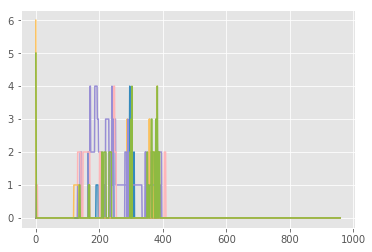

In [5]:
#Nd, Na, Nt
reinout_flags = np.load('/home/albert/lofar1_1/imaging/data/flagsTECBay.npy')

plt.plot(reinout_flags.sum(0).T)
plt.show()

In [ ]:
recalculate_weights = False
ant_cutoff = 0.2
ref_dir_idx = 14
block_size = 20

datapack = DataPack(reinout_datapack, readonly=True)
select = dict(pol=slice(0,1,1),
             ant=slice(None,None,1),
             dir=slice(None,None,1),
             time=slice(None,None,1))
datapack.current_solset = 'data_posterior'
datapack.select(**select)
axes = datapack.axes_tec

###
# cutoff dist for antennas
antenna_labels, antennas = datapack.get_antennas(axes['ant'])
Xa  = antennas.cartesian.xyz.to(dist_type).value.T

ref_ant = Xa[0,:]
Na = len(antennas)
keep=[]

for i in range(1, Na):
    if np.all(np.linalg.norm(Xa[i:i+1,:] - Xa[keep,:], axis=1) > ant_cutoff):
        keep.append(i)
        
logging.info("Training on {} antennas".format(len(keep)))
        
###
# Load data


select['ant'] = keep
datapack.select(**select)
tec, axes = datapack.tec
tec -= tec[:,ref_dir_idx:ref_dir_idx+1,:,:]
tec_uncert, _ = datapack.weights_tec

#Nd, Na, Nt -> Nt, Nd, Na
tec = tec[0,...].transpose((2,0,1))
Nt, Nd, Na = tec.shape
_, times = datapack.get_times(axes['time'])
Xt = (times.mjd*86400.)[:, None]
_, directions = datapack.get_directions(axes['dir'])
Xd = np.stack([directions.ra.to(angle_type).value, directions.dec.to(angle_type).value],axis=1)
ref_dir = Xd[ref_dir_idx,:]
ants, antennas = datapack.get_antennas(axes['ant'])
Xa = antennas.cartesian.xyz.to(dist_type).value.T

datapack.current_solset = 'screen_posterior'
datapack.select(**select)
axes = datapack.axes_tec
_, screen_directions = datapack.get_directions(axes['dir'])
Xd_screen = np.stack([screen_directions.ra.to(angle_type).value, screen_directions.dec.to(angle_type).value],axis=1)
Nd_screen = Xd_screen.shape[0]
# Xd_screen = np.stack([np.random.uniform(-6*np.pi/180., 6.*np.pi/180.,size=Nd_screen) + directions.ra.to(angle_type).value.mean(), 
#                       np.random.uniform(-6*np.pi/180., 6.*np.pi/180.,size=Nd_screen) + directions.dec.to(angle_type).value.mean()],axis=1)

with tf.Session(graph=tf.Graph()) as sess:
    
    with gp.defer_build():
        kern = DTECKernel(13, variance=1., lengthscales=10.0,
                     a = 200., b = 100., resolution=4,
                     fed_kernel='M52', obs_type='DDTEC')
        kern.lengthscales.prior = gp.priors.Gaussian(15.,5.**2)
        kern.a.prior = gp.priors.Gaussian(250.,100.**2)
        kern.b.prior = gp.priors.Gaussian(100.,50.**2)
        kern.variance = 2.1**2
        kern.lengthscales = 9.5
        kern.a = 250.
        kern.b = 100.
        
    posterior_screen_mean = []
    posterior_screen_std = []
    outlier_masks = []

    #assumes K doesn't change over this time
    
    for t in range(0,Nt, block_size):
        start = t
        stop = min(Nt,t+block_size)
        mid_time = start + (stop-start)//2
        
        #block_size, Nd, Na
        outlier_mask = flags[start:stop, :, :]
        
        X = make_coord_array(Xt[mid_time:mid_time+1], Xd, Xa,flat=False)[0,...]
        X = sess.run(ITRSToENUWithReferences(ref_ant, ref_dir, ref_ant)(X))
        X = X.reshape((-1,13))

        X_screen = make_coord_array(Xt[t:t+1,:], Xd_screen, Xa,flat=False)[0,...]
        X_screen = sess.run(ITRSToENUWithReferences(ref_ant, ref_dir, ref_ant)(X_screen))
        X_screen = X_screen.reshape((-1,13))
    
        #T, N
        Y = tec[start:stop, :, :].reshape((stop-start, -1))
        #T, N
        detection = tec_uncert[start:stop, :, :].reshape((stop-start, -1))
        

        
        if recalculate_weights:
            ###
            # First outlier filter
            
            Y_var = 10.**2*np.ones_like(Y)

            model = HGPR(X,Y,Y_var, kern)
            ystar, varstar = model.predict_f(X)
            stdstar = np.sqrt(varstar)
            cdf = 0.5*(1. + erf((Y - ystar)/stdstar/np.sqrt(2.)))
            detection = cdf > 0.9
            mask = np.logical_not(detection)
            logging.info("First round of filtering: {} outliers".format(detection.sum()))
            Y_var = np.where(detection, 200.**2, 1.)


            ###
            # Refined outlier filter    
            model = HGPR(X,Y,Y_var, kern)
            ystar, varstar = model.predict_f(X)
            stdstar = np.sqrt(varstar)
            cdf = 0.5*(1. + erf((Y - ystar)/stdstar/np.sqrt(2.)))
            detection = cdf > 0.9
            mask = np.logical_not(detection)
            logging.info("Second round of filtering: {} outliers".format(detection.sum()))
        
        ###
        # Predict
        Y_var = np.where(detection, 200.**2, 1.0)
        model = HGPR(X,Y,Y_var, kern)
        logging.info("Index {} -> training hyperparams".format(t))
        gp.train.ScipyOptimizer().minimize(model)
        logging.info(str(kern.read_trainables()))
        logging.info("Done index {} -> training hyperparams".format(t))
        Y_var = np.where(detection, 200.**2, 0.5)
        model = HGPR(X,Y,Y_var, kern)
    
        logging.info("Predicting screen from {} to {}".format(start, stop))
        ystar, varstar = model.predict_f(X_screen)
        logging.info("Done predicting screen from {} to {}".format(start, stop))
        
        ystar = ystar.reshape((stop-start, Nd_screen, Na))
        stdstar = np.sqrt(varstar).reshape((stop-start, Nd_screen, Na))
        
        posterior_screen_mean.append(ystar)
        posterior_screen_std.append(stdstar)
#         outlier_masks.append(detection.reshape((stop-start, Nd, Na)))
    posterior_screen_mean = np.concatenate(posterior_screen_mean,axis=0).transpose((1,2,0))[None, :,:,:]
    posterior_screen_std = np.concatenate(posterior_screen_std,axis=0).transpose((1,2,0))[None, :,:,:]
#     outlier_masks = np.concatenate(outlier_masks,axis=0).transpose((1,2,0))[None, :,:,:]
    
logging.info("Storing")
datapack = DataPack(reinout_datapack, readonly=False)
select = dict(pol=slice(0,1,1),
             ant=slice(None,None,1),
             dir=slice(None,None,1),
             time=slice(None,None,1))
datapack.current_solset = 'data_posterior'
datapack.select(**select)
datapack.tec = posterior_screen_mean
datapack.weights_tec = posterior_screen_std
logging.info("Done")